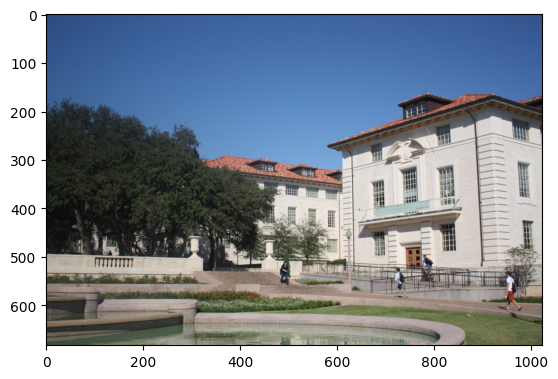

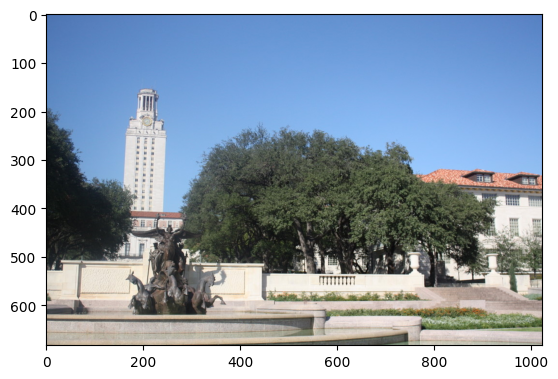

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

img1 = cv2.imread('images/1.jpg')
img2 = cv2.imread('images/2.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

plt.imshow(img1)
plt.show()

plt.imshow(img2)
plt.show()


In [19]:
window_name = 'Image Correspondences'
correspondences = []

def mouse_callback(event, x, y, flags, param):
    global correspondences
    if event == cv2.EVENT_LBUTTONDOWN:
        correspondences.append((x, y))
        cv2.circle(img, (x, y), 3, (0, 255, 0), -1)
        cv2.imshow(window_name, img)
        print(f"Point selected: ({x}, {y})")


cv2.imshow(window_name, img1)
img = img1.copy()
cv2.setMouseCallback(window_name, mouse_callback)
cv2.waitKey(0)

points1 = np.array(correspondences)
correspondences = []

cv2.imshow(window_name, img2)
img = img2.copy()
cv2.setMouseCallback(window_name, mouse_callback)
cv2.waitKey(0)

points2 = np.array(correspondences)

cv2.destroyAllWindows()

print(points1)
print(points2)    

Point selected: (178, 507)
Point selected: (104, 504)
Point selected: (444, 297)
Point selected: (531, 311)
Point selected: (636, 544)
Point selected: (567, 544)
Point selected: (890, 322)
Point selected: (984, 328)
[[178 507]
 [104 504]
 [444 297]
 [531 311]]
[[636 544]
 [567 544]
 [890 322]
 [984 328]]


In [20]:
def get_homography_matrix(points1, points2):
    A = np.zeros((8, 9))
    for i in range(4):
        x, y = points1[i]
        u, v = points2[i]
        A[2*i] = [-x, -y, -1, 0, 0, 0, u*x, u*y, u]
        A[2*i+1] = [0, 0, 0, -x, -y, -1, v*x, v*y, v]

    U, S, V = np.linalg.svd(A)
    H = V[-1].reshape((3, 3))
    H /= H[2, 2]
    H[2, 2] = 1
    return H
    

h=get_homography_matrix(points1, points2)
print(h)
print("--------------")
homogeneous_point = np.array([points1[0][0], points1[0][1], 1])
homogeneous_point = homogeneous_point.reshape((3, 1))
print(homogeneous_point)
print(h.shape)
print(homogeneous_point.shape)
x= np.dot(h, homogeneous_point)
x=x/x[2]
print("-----------------")
print(x)
print(points2[0])


[[ 7.50949097e-01 -1.76842070e-03  4.59411786e+02]
 [-1.47432695e-01  8.60237818e-01  9.66247257e+01]
 [-2.04307595e-04 -6.41540761e-05  1.00000000e+00]]
--------------
[[178]
 [507]
 [  1]]
(3, 3)
(3, 1)
-----------------
[[636.]
 [544.]
 [  1.]]
[636 544]


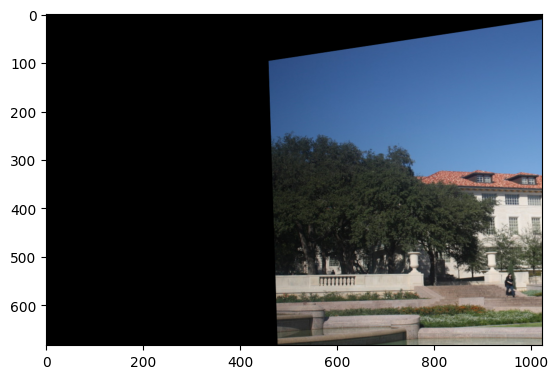

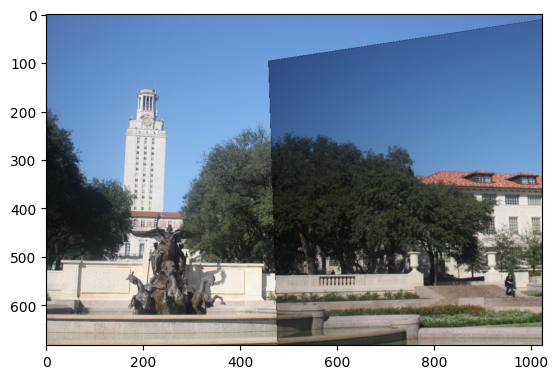

In [30]:
warped_img = cv2.warpPerspective(img1, h, (img1.shape[1], img1.shape[0]))
plt.imshow(warped_img)
plt.show()

# accumulated_img = warped_img.copy()
# accumulated_img[warped_img == 0] = img2[warped_img == 0]
# plt.imshow(accumulated_img)
# plt.show()


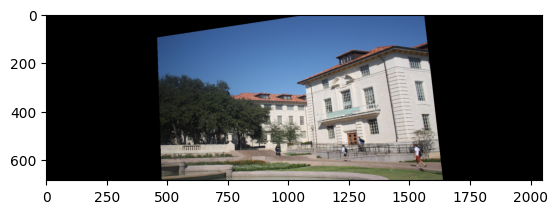

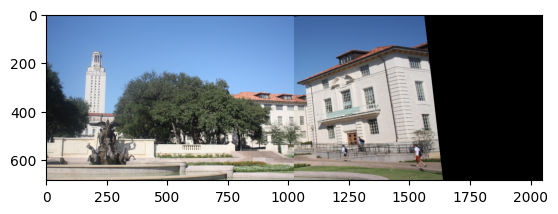

In [31]:
def print_img(img , title = None):
  plt.imshow(img, cmap = plt.get_cmap(None))
  plt.show()
  plt.close()
  print()
  return
def warp(img, H):
  ret = np.zeros((img.shape[0], img.shape[1]*2, 3, 2))
  ret_img = np.zeros((img.shape[0], img.shape[1]*2, 3))
  shape = img.shape
  for i in range(shape[1]):
    for j in range(shape[0]):
      pt = np.array([(i, j, 1)]).T
      pos = H.dot(pt)
      x, y = pos[0] / pos[2], pos[1] / pos[2]
      arr = np.reshape(np.array([(np.floor(x), np.floor(x), np.ceil(x), np.ceil(x)),
                      (np.floor(y), np.ceil(y), np.floor(y), np.ceil(y))]), (2, 4)).T
      arr = np.unique(arr, axis = 0)
      for k in range(len(arr)):
        x, y = int(arr[k][0]), int(arr[k][1])
        if x >= 0 and y >= 0 and x < ret.shape[1] and y < ret.shape[0]:
          for col in range(3):
            ret[y][x][col][0] += 1
            ret[y][x][col][1] += img[j][i][col] 
  
  for i in range(ret.shape[0]):
    for j in range(ret.shape[1]):
      for k in range(ret.shape[2]):
        if ret[i][j][k][0] > 0:
          ret_img[i][j][k] = np.round(ret[i][j][k][1]/ret[i][j][k][0]).astype(int)
  return ret_img

dst = warp(img1, h).astype(int)
plt.imshow(dst)
plt.show()
dst[0:img2.shape[0], 0:img2.shape[1]] = img2
print_img(dst, title = 'Final output')